<a href="https://colab.research.google.com/github/adamehayman/AMII/blob/main/4_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [2]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 129 (delta 67), reused 86 (delta 31), pack-reused 0
Receiving objects: 100% (129/129), 30.34 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb			   FIgures.pptx
2_10_Class_Decision_Tree_Classifier.ipynb  NASA_TurboFan_Data
3_5_Class_Decision_Tree_Classifier.ipynb   README.md


In [3]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_test.csv')

In [4]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

### **Train RandomForest**

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [33]:
RndFor = RandomForestClassifier(random_state=42)

In [38]:
param_dict = {
    'class_weight':['balanced', 'balanced_subsample'],
    'n_estimators':range(100,500,50),
}

In [39]:
RndForGrid = GridSearchCV(RndFor,
                          param_grid=param_dict,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
RndForGrid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 41.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [40]:
RndForGrid.best_params_

{'class_weight': 'balanced', 'n_estimators': 350}

In [41]:
RndForGrid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [42]:
RndForGrid.best_score_

0.8634887480016793

In [44]:
RndForScore = RndForGrid.best_score_

In [14]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 7.9MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


#### **Random Forest Evaluation**

##### **Classification Report**

In [15]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

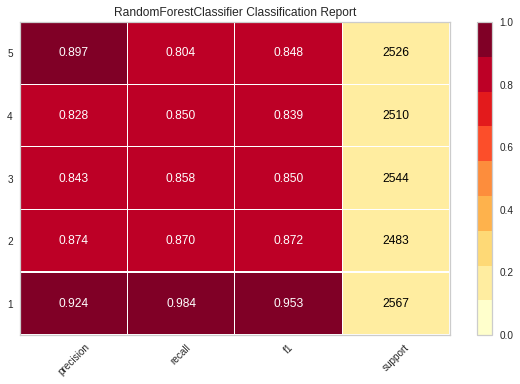

In [45]:
viz = ClassificationReport((RndFor), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

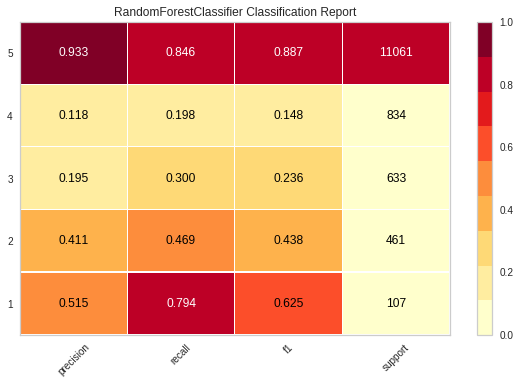

In [46]:
viz = ClassificationReport((RndFor), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()